<hr style="border:2px solid gray"> </hr>

# Homework 1 - Traveling Salesman Problem

## Example Code

### Algorithm 4: Genetic Algorithm 

### Author: Wangduk Seo (CAU AI Lab)
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

---------------------------------------------------------------
## (Optional) For Colab

In [ ]:
# from google.colab import drive
# import os, sys
# drive.mount('gdrive', force_remount=True)

---------------------------------------------------------------

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# GA
POOL_SIZE = 20 
TOURNAMENT_SIZE = 10
MAX_ITERATION = 100000

# SA
MAX_EVALUATION = 50
SUB_ITERATIONS = 20
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

np.random.seed(0)
# Plot Settings
PLOT_MODE = True # Draw Route
plt.ion()

# First City Index
FIRST_IDX = 0

In [2]:
file_path = 'data2.txt'

# Step 1. Data Loading

In [3]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

# Step 2. Initialization

In [4]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path


def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 4. Genetic Algorithm 

In [5]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [6]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            
    return best_path, best_cost

In [7]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(POOL_SIZE)
    
    path_map, path_pool[0, :] = initialize_greedy(coord_list, FIRST_IDX)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

    print('Path {} is initialized'.format(0))

    for i in range(1, POOL_SIZE):
        _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
        path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list)
        print('Path {} is initialized'.format(i))
    
    return path_pool, pool_cost, path_map

In [8]:
def selection(pool_cost, TOURNAMENT_SIZE, sel_size=2):
    # tournament selection
#     sel_idx = np.random.choice(POOL_SIZE, TOURNAMENT_SIZE, replace=False)
    sel_idx = np.random.choice(pool_cost.shape[0], TOURNAMENT_SIZE, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

In [72]:
# ox crossover
def oxcrossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Initialize child path 1~4
    child_path_1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_3 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_4 = np.zeros(cnt_cities + 1, dtype=np.int32)
    
    child_path_1[0], child_path_1[-1] = -1, -1
    child_path_2[0], child_path_2[-1] = -1, -1
    child_path_3[0], child_path_3[-1] = -1, -1
    child_path_4[0], child_path_4[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path_1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path_2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Copy the rest of the path from another path
    try:
        path2_idx = np.where(np.isin(path2, child_path_1) == False)[0]
        child_path_1[np.where(child_path_1 == 0)[0]] = path2[path2_idx]
        child_path_1[0], child_path_1[-1] = FIRST_IDX, FIRST_IDX

        path1_idx = np.where(np.isin(path1, child_path_2) == False)[0]
        child_path_2[np.where(child_path_2 == 0)[0]] = path1[path1_idx]
        child_path_2[0], child_path_2[-1] = FIRST_IDX, FIRST_IDX
    except:
#         print('ox')
        return [path1, path2]

    
    # Reverse the subpath and save to child path 3 4
    child_path_3 = child_path_1.copy()
    child_path_3[sel_idx[0]:sel_idx[1]] = np.flip(child_path_3[sel_idx[0]:sel_idx[1]])
    child_path_4 = child_path_2.copy()
    child_path_4[sel_idx[0]:sel_idx[1]] = np.flip(child_path_4[sel_idx[0]:sel_idx[1]])
    
    return [child_path_1, child_path_2, child_path_3, child_path_4]

In [73]:
# pmx crossover
def pmxcrossover(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Initialize child paths 1~4
    child_path_1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_3 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path_4 = np.zeros(cnt_cities + 1, dtype=np.int32)
    
    child_path_1[0], child_path_1[-1] = -1, -1
    child_path_2[0], child_path_2[-1] = -1, -1
    child_path_3[0], child_path_3[-1] = -1, -1
    child_path_4[0], child_path_4[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path_1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path_2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Replace cities in path to partially mapped subpath
    try:
        path2_argsort = np.argsort(path2)
        path2_idx = path2_argsort[np.searchsorted(path2, path1[sel_idx[0]:sel_idx[1]], sorter=path2_argsort)]
        path2_replaced = path2.copy()
        path2_replaced[path2_idx] = path2[sel_idx[0]:sel_idx[1]]

        path1_argsort = np.argsort(path1)
        path1_idx = path1_argsort[np.searchsorted(path1, path2[sel_idx[0]:sel_idx[1]], sorter=path1_argsort)]
        path1_replaced = path1.copy()
        path1_replaced[path1_idx] = path1[sel_idx[0]:sel_idx[1]]
    except:
#         print('pmx')
        return [path1, path2]
    
    # Copy the rest of the path from the replaced path
    child_path_1[:sel_idx[0]], child_path_1[sel_idx[1]:] = path2_replaced[:sel_idx[0]], path2_replaced[sel_idx[1]:]
    child_path_2[:sel_idx[0]], child_path_2[sel_idx[1]:] = path1_replaced[:sel_idx[0]], path1_replaced[sel_idx[1]:]
    
    # Reverse the subpath and save to child path 3 4
    child_path_3 = child_path_1.copy()
    child_path_3[sel_idx[0]:sel_idx[1]] = np.flip(child_path_3[sel_idx[0]:sel_idx[1]])
    child_path_4 = child_path_2.copy()
    child_path_4[sel_idx[0]:sel_idx[1]] = np.flip(child_path_4[sel_idx[0]:sel_idx[1]])
    
    return [child_path_1, child_path_2, child_path_3, child_path_4]

In [11]:
# 2-opt mutation
def mutation_2opt(path):
    cnt_cities = len(path)
    child_path = path.copy()
    
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])

    return child_path 

In [12]:
# single point mutation
def mutation_singlepoint(path):
    cnt_cities = len(path)
    child_path = np.zeros(cnt_cities, dtype=np.int32)
    
    # Select single index of mutation point
    sel_idx = np.random.choice(np.arange(2, cnt_cities-2), 1)[0]
    
    # Swap two subpaths divided by single mutation point
    child_path[1:cnt_cities-sel_idx] = path[sel_idx:cnt_cities-1]
    child_path[cnt_cities-sel_idx:-1] = path[1:sel_idx]
    
    return child_path

In [13]:
# three-point mutation
def mutation_threepoint(path):
    cnt_cities = len(path)
    child_path = path.copy()
    
    # Select three indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities-2), 3))
    
    # Swap the subpaths
    child_path[sel_idx[0]:sel_idx[0]+sel_idx[2]-sel_idx[1]], child_path[sel_idx[0]+sel_idx[2]-sel_idx[1]:sel_idx[2]] = path[sel_idx[1]:sel_idx[2]], path[sel_idx[0]:sel_idx[1]]
    
    return child_path

In [74]:
# genetic algorithm
def ga(coord_list):
    ga_start_time = time.time()
    best_cost = np.Inf
    print('Start Genetic Algorithm')
    print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    print('Start the evolution')
    for i in range(MAX_ITERATION):
        if time.time() - ga_start_time > 58:
            print('timeout')
            break
        if (i+1) % 1000 == 0:
            print('Iteration {}'.format(i + 1))
            
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=7)
        
        # OX crossover
        child_ox_list = oxcrossover(path_pool[sel_idx[0]], path_pool[sel_idx[2]])
        cost_ox_list = []
        for child in child_ox_list:
            cost_ox_list.append(path_cost(path_map, child).sum())
        
        # PMX crossover
        child_pmx_list = pmxcrossover(path_pool[sel_idx[1]], path_pool[sel_idx[3]])
        cost_pmx_list = []
        for child in child_pmx_list:
            cost_pmx_list.append(path_cost(path_map, child).sum())
        
        # 2opt mutation
        child_mut_swap = mutation_2opt(path_pool[sel_idx[4]])
        cost_mut_swap = path_cost(path_map, child_mut_swap).sum()
        
        # single point mutation
        child_mut_singlepoint = mutation_singlepoint(path_pool[sel_idx[5]])
        cost_mut_singlepoint = path_cost(path_map, child_mut_singlepoint).sum()
        
        # three-point mutation
        child_mut_threepoint = mutation_threepoint(path_pool[sel_idx[6]])
        cost_mut_threepoint = path_cost(path_map, child_mut_threepoint).sum()
        
        # replacement
        # add all child solution to the pool
        path_pool = np.concatenate((path_pool, np.array(child_ox_list), np.array(child_pmx_list),
                                    np.array([child_mut_swap, 
#                                               child_mut_singlepoint, 
#                                               child_mut_threepoint
                                             ])
                                   ))
        pool_cost = np.concatenate((pool_cost, cost_ox_list, cost_pmx_list, 
                                    [cost_mut_swap, 
#                                      cost_mut_singlepoint, 
#                                      cost_mut_threepoint
                                    ]
                                   ))
        
        # keep best solution in pool
        pool_argsort = np.argsort(pool_cost)
        best_path = path_pool[pool_argsort[0],:]
        best_cost = pool_cost[pool_argsort[0]]
        
        path_pool = path_pool[pool_argsort[1:],:]
        pool_cost = pool_cost[pool_argsort[1:]]
        
        # selection with tournament selection algorithm
        rep_idx = selection(pool_cost, TOURNAMENT_SIZE=(POOL_SIZE+pool_cost.shape[0])//2, sel_size=POOL_SIZE-1)
        
        path_pool = path_pool[rep_idx, :]
        pool_cost = pool_cost[rep_idx]
        
        path_pool = np.concatenate((path_pool, np.array([best_path])))
        pool_cost = np.concatenate((pool_cost, np.array([best_cost])))
        
#         print(path_pool.shape, pool_cost.shape)

        cur_idx = np.argmin(pool_cost)
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]
        
        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE:
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()

    best_idx = np.argmin(pool_cost)
    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route: Iteration {}'.format(i + 1))
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[cur_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()
    return path_pool[best_idx], pool_cost[best_idx]

# Main

In [75]:
file_path = 'data1.txt'

Start Genetic Algorithm
Initialize the population
Path 0 is initialized
Path 1 is initialized
Path 2 is initialized
Path 3 is initialized
Path 4 is initialized
Path 5 is initialized
Path 6 is initialized
Path 7 is initialized
Path 8 is initialized
Path 9 is initialized
Path 10 is initialized
Path 11 is initialized
Path 12 is initialized
Path 13 is initialized
Path 14 is initialized
Path 15 is initialized
Path 16 is initialized
Path 17 is initialized
Path 18 is initialized
Path 19 is initialized
Start the evolution
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000
Iteration 30000
Iteration

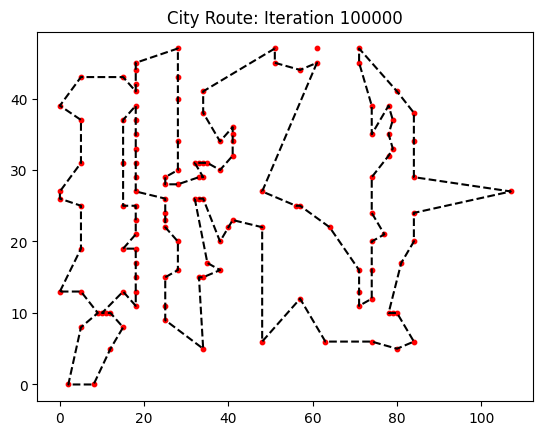

Execution Time: 41.844764947891235
Path: [0, 6, 7, 1, 2, 8, 9, 3, 10, 23, 40, 41, 42, 43, 60, 59, 58, 57, 56, 51, 50, 55, 65, 69, 62, 66, 70, 75, 78, 82, 83, 84, 85, 79, 71, 72, 90, 89, 94, 95, 95, 87, 91, 93, 98, 101, 100, 99, 104, 105, 106, 112, 107, 108, 114, 118, 115, 119, 116, 109, 110, 102, 103, 121, 128, 127, 126, 130, 125, 124, 123, 113, 117, 120, 129, 122, 111, 97, 92, 88, 86, 81, 80, 77, 68, 64, 61, 74, 76, 67, 63, 73, 52, 44, 45, 53, 54, 46, 47, 48, 49, 33, 34, 35, 36, 37, 38, 39, 22, 21, 20, 32, 31, 30, 19, 29, 28, 27, 26, 25, 18, 14, 15, 16, 24, 17, 12, 4, 11, 13, 5, 0]
Cost: 610.668723980688


In [76]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

### data2: 

In [77]:
file_path = 'data2.txt'

Start Genetic Algorithm
Initialize the population
Path 0 is initialized
Path 1 is initialized
Path 2 is initialized
Path 3 is initialized
Path 4 is initialized
Path 5 is initialized
Path 6 is initialized
Path 7 is initialized
Path 8 is initialized
Path 9 is initialized
Path 10 is initialized
Path 11 is initialized
Path 12 is initialized
Path 13 is initialized
Path 14 is initialized
Path 15 is initialized
Path 16 is initialized
Path 17 is initialized
Path 18 is initialized
Path 19 is initialized
Start the evolution
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
timeout


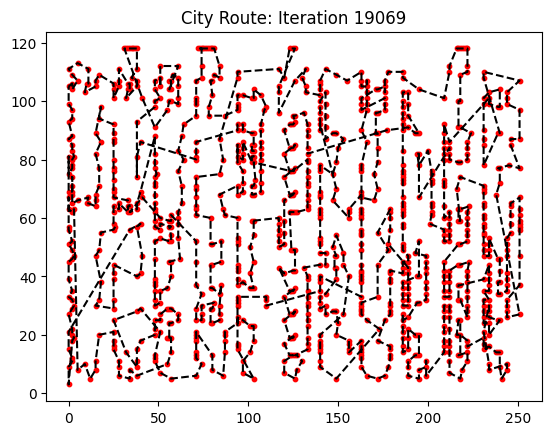

Execution Time: 58.06992506980896
Path: [0, 22, 21, 54, 23, 1, 55, 63, 62, 60, 59, 67, 68, 78, 91, 90, 89, 118, 119, 121, 131, 137, 136, 130, 127, 148, 149, 144, 151, 152, 147, 146, 145, 138, 132, 128, 126, 170, 203, 224, 225, 235, 263, 251, 252, 253, 250, 227, 237, 236, 226, 254, 209, 207, 208, 175, 174, 206, 173, 204, 163, 160, 161, 169, 293, 294, 295, 296, 384, 385, 402, 401, 418, 434, 433, 417, 416, 432, 431, 415, 414, 400, 399, 398, 397, 381, 382, 383, 380, 396, 395, 393, 378, 379, 342, 349, 355, 377, 376, 375, 374, 373, 372, 371, 370, 369, 392, 405, 410, 423, 406, 424, 407, 426, 427, 411, 460, 459, 458, 457, 456, 455, 468, 469, 470, 471, 504, 519, 492, 482, 473, 520, 505, 555, 554, 553, 552, 551, 550, 549, 548, 547, 546, 525, 518, 503, 491, 481, 490, 502, 516, 515, 501, 467, 454, 480, 489, 500, 514, 466, 479, 488, 499, 513, 465, 478, 487, 498, 512, 464, 477, 486, 497, 463, 472, 517, 526, 528, 524, 511, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 529, 580, 606, 607

In [78]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))

### data 3: 

In [79]:
file_path = 'data3.txt'

Start Genetic Algorithm
Initialize the population
Path 0 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 1 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 2 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 3 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 4 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 5 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 6 is initialized
Path 7 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 8 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 9 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 10 is initialized
Path 11 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 12 is initialized
Path 13 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 14 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 15 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 16 is initialized
Path 17 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 18 is initialized


/var/folders/qy/qpwfmy2x5kz6jkcq1rb246x80000gn/T/ipykernel_66155/2948270870.py:38: RuntimeWarning: overflow encountered in exp
  prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))


Path 19 is initialized
Start the evolution
Iteration 1000
Iteration 2000
Iteration 3000
timeout


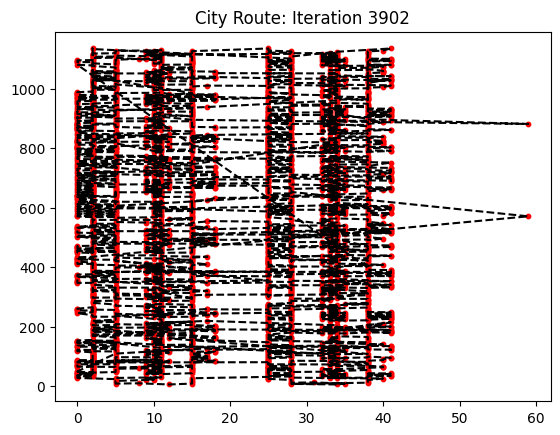

Execution Time: 58.08475089073181
Path: [0, 209, 208, 582, 581, 580, 579, 578, 577, 206, 207, 204, 576, 575, 574, 573, 572, 571, 198, 199, 200, 202, 203, 864, 978, 1216, 1479, 1215, 977, 976, 1214, 863, 975, 1213, 1212, 974, 861, 1478, 1537, 1805, 1804, 1536, 1477, 1211, 973, 860, 972, 1210, 1209, 971, 859, 858, 970, 1207, 1206, 969, 857, 1205, 1204, 968, 967, 1203, 1532, 1533, 1534, 1535, 566, 567, 191, 192, 193, 194, 195, 569, 568, 190, 189, 188, 187, 186, 184, 183, 182, 181, 180, 563, 562, 561, 560, 178, 179, 852, 851, 559, 558, 557, 176, 175, 174, 173, 172, 171, 554, 553, 847, 848, 849, 850, 1475, 1527, 1774, 1887, 1886, 1773, 1772, 1885, 1884, 1771, 1525, 1472, 1197, 963, 1196, 1471, 1470, 1195, 962, 961, 1194, 1469, 1524, 1768, 1881, 1880, 1767, 1523, 1468, 1193, 960, 1191, 1466, 1465, 1190, 959, 958, 1189, 1464, 1766, 1765, 1764, 1461, 1187, 1188, 1462, 1463, 957, 838, 837, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 547, 166, 165, 164, 163, 839, 840, 841, 842, 548, 1

In [80]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))